<h1 style="font-size:300%">Iris classification with Nearest Neighbors</h1>

BSHT Michielsen MSc

This notebook demonstrates how to use the [sklearn Nearest Neighbors classifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) algorithm to classify iris flowers based on simple measurements of their petals and sepals. The iris is a flower with a particular appearance because it has different parts that are shaped significantly different among the three typical species, see the image below. Therefore, it is relatively easy for a human to identify which species of iris we are dealing with based on the shape of those parts, and it is also relatively easy to let a machine classify them using the same metrics. Note that is a classification problem, so we use the `classifier` variety of nearest neighbors. A `regression` variety exists as well for other problems. The data used in this notebook comes from [UCI Irvine Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Iris). The image below is from https://machinelearninghd.com.

<img src="https://machinelearninghd.com/wp-content/uploads/2021/03/iris-dataset.png" />


First, the versions of the required libraries are shown. It always wise to report the versions of the libraries used so that in case problems arise in the future, one can still go back to a state in which the notebook worked.

In [32]:
import sklearn
import pandas
import seaborn

print("scikit-learn version:", sklearn.__version__)     # 1.4.1
print("pandas version:", pandas.__version__)            # 2.2.0
print("seaborn version:", seaborn.__version__)          # 0.13.2

scikit-learn version: 1.7.1
pandas version: 2.3.2
seaborn version: 0.13.2


# 📦 Data provisioning
In real life your data provisioning is likely to include more steps about data sourcing and data quality, however for demo purposes in this notebook we limit it to merely loading the data using the [pandas read_csv](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) function, without any concern over quantity nor quality. The data has 150 observations in 5 columns namely 4 features about the iris flowers and 1 target variable, the name of the iris species.

In [33]:
columns = ["Sepal Length", "Sepal Width", "Petal Length", "Petal Width", "Species"]
df = pandas.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data", names=columns)
df.shape

(150, 5)

# 📃 Sample the data
To get an impression of the data and have a look at the features, a sample of 10 observations from the set is taken. The idea here is that a certain combination of values for the features is more likely to mean a certain species. For example `iris-setosa` seems to have a relatively small `Petal Width` and `iris-versicolor` has a relatively high `Sepal Length`. Knowing this, one could, given the lengths and widths for sepal and petal make an educated guess as to the species by looking at how close its values are to already existing observations. This is the idea of Nearest Neighbors, it looks for "how close" a new observation is to previous known observations. In the second part we look at how many observations there are for each of the classes in the target variable by using a groupby function. Because this dataset is very balanced there are exactly 50 observations for each of the 3 classes.

In [34]:
df.sample(10)

,Sepal Length,Sepal Width,Petal Length,Petal Width,Species
100,6.3,3.3,6.0,2.5,Iris-virginica
98,5.1,2.5,3.0,1.1,Iris-versicolor
148,6.2,3.4,5.4,2.3,Iris-virginica
134,6.1,2.6,5.6,1.4,Iris-virginica
13,4.3,3.0,1.1,0.1,Iris-setosa
137,6.4,3.1,5.5,1.8,Iris-virginica
105,7.6,3.0,6.6,2.1,Iris-virginica
47,4.6,3.2,1.4,0.2,Iris-setosa
57,4.9,2.4,3.3,1.0,Iris-versicolor
63,6.1,2.9,4.7,1.4,Iris-versicolor


In [35]:
group_info = df.groupby(["Species"])["Species"].count()
group_info

Species
Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: Species, dtype: int64

# 🛠️ Preprocessing
The step of preprocessing contains several activities to consider before we can start training the algorithm and produce a model that can predict our target variable, in this case the species of an iris flower. 

### 🎯 Target variable
Given that machine learning algorithms work with only numbers and therefore produce only numbers as output, the first thing that needs to be done is ascertaining that the target variable is numeric. A new column named `Species ID` is made, that contains a number for ech of the different `Species`, and that becomes the target variable for our model. The thing it needs to predict. In order to fill the new column `Species ID` a LabelEncoder is used, which produces a unique number for every unique text it finds in the column `Species`. Since there are merely three unique values, the numbers it will give are `0`, `1` and `2`.

In [36]:
from sklearn import preprocessing
encoder = preprocessing.LabelEncoder()
df["Species ID"] = encoder.fit_transform(df["Species"])
df.sample(10)

,Sepal Length,Sepal Width,Petal Length,Petal Width,Species,Species ID
127,6.1,3.0,4.9,1.8,Iris-virginica,2
56,6.3,3.3,4.7,1.6,Iris-versicolor,1
92,5.8,2.6,4.0,1.2,Iris-versicolor,1
75,6.6,3.0,4.4,1.4,Iris-versicolor,1
116,6.5,3.0,5.5,1.8,Iris-virginica,2
143,6.8,3.2,5.9,2.3,Iris-virginica,2
101,5.8,2.7,5.1,1.9,Iris-virginica,2
96,5.7,2.9,4.2,1.3,Iris-versicolor,1
64,5.6,2.9,3.6,1.3,Iris-versicolor,1
120,6.9,3.2,5.7,2.3,Iris-virginica,2


### 💡 Feature selection
Perhaps the most important step is 'feature selection', which is the activity of deciding which of the candidate features to use in order to predict the target variable. A common mistake is to just take all features "because knowing more, implies a higher chance of guessing correct", which is not true. Sometimes some features do not help at all, and some even produce noise in the algorithm. It is therefore important to pick only those features that can together explain the variance in the target variable the best. For a classification algorithm that would mean that any feature that has well distinguishable values per class would be good. A way to look for this is by creating a [box plot](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.boxplot.html).

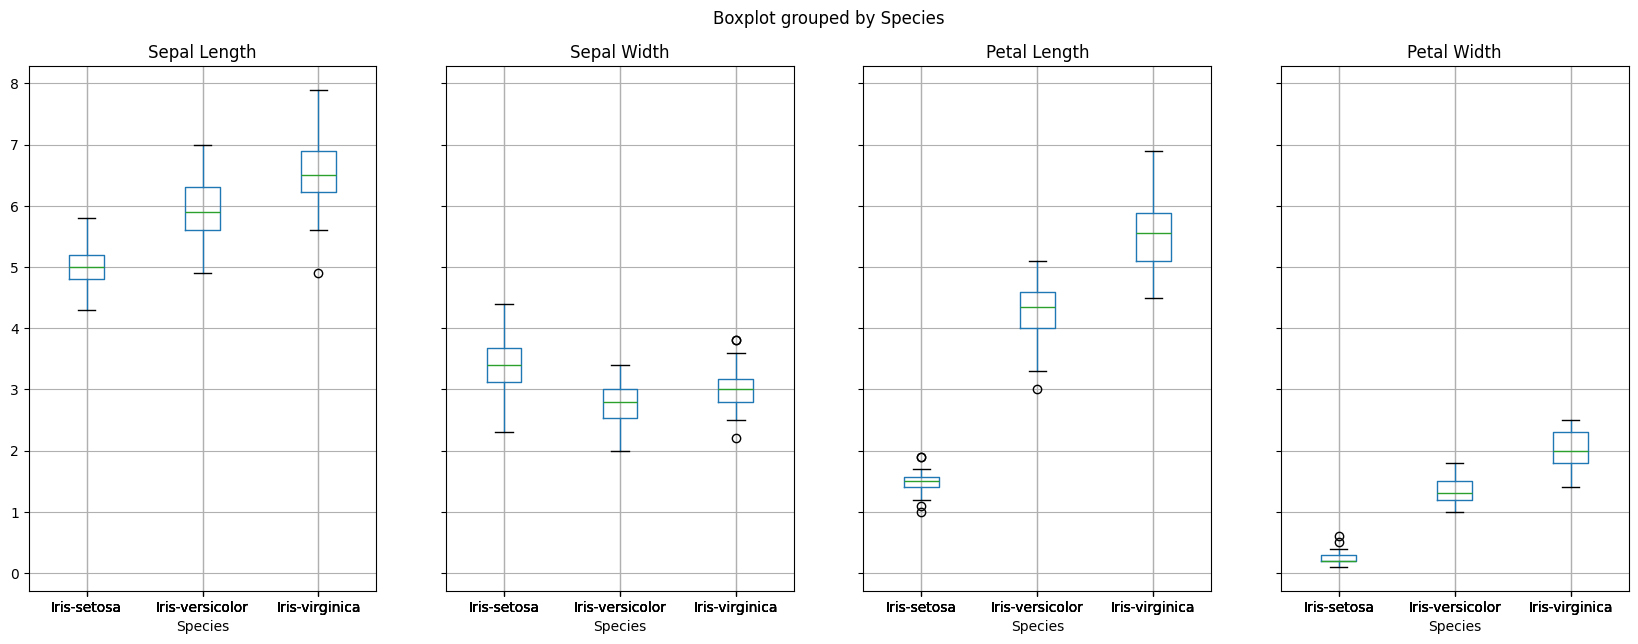

In [37]:
candidates = columns[:-1]
plot = df.boxplot(column=candidates, by="Species", figsize=(20,7), layout=(1,len(candidates)))

The idea here is that if the boxes are vertically close to each other, thus overlapping the same value space, that feature would be less good because the values of that feature are close to each other and therefore hard to distinguish. In contrast, a feature in which the boxes are vertically far away from each other would be a good feature. Now, in this dataset any feature is still a fair choice, but for example `Petal Length`, having boxes far away from each other, would be a better choice than `Sepal Width` where the boxes are closer to each other. Also `Petal Width` seems to be a fair choice. The selected features are put into a variable named `X` and the target variable is put into a variable named `y`.

In [38]:
features = ["Petal Length", "Petal Width"]
target = "Species ID"
X = df[features]
y = df[target]

### 🪓 Splitting into train/test
Before the model can be trained, a little part of the data is to be put aside for testing purposes. The reasoning here is that the model trains with, for example 80% of the data available, and the other 20% is used to ask it to predict the target variable for. Now, because the true target variable of that 20% is known, we can compare the predictions us with the ground truth and devise how well the model performs.

In [39]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print("There are in total", len(X), "observations, of which", len(X_train), "are now in the train set, and", len(X_test), "in the test set.")

There are in total 150 observations, of which 120 are now in the train set, and 30 in the test set.


### ⚖️ Scaling
The Nearest Neighbors algorithm uses the concept of "being near" as to decide which species an unknown iris would be. This "being near" is calculated using [Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance), which is an absolute measurement between two values of the same feature, but not among features. It is therefore needed to scale all the features such that they use the same unit of measurement. Here is an example that demonstrates why:
> Given the numbers 6 and 8, the Euclidean distance would be 2. Given the numbers 95 and 100 the Euclidean distance would be 5. However, 95 and 100 are in fact closer to each other (95%) than 6 and 8 are (75%).

Therefore it is important that among features the same unit is used. A common unit to use is [standard deviation](https://en.wikipedia.org/wiki/Standard_deviation), and sklearn provides the `StandardScaler` to transform all values into that same unit. After that we can make a scatter plot to see the actual distances between the iris flowers. Note that the distance is in standard deviations (σ).

<Axes: title={'center': 'Distance between iris flowers (σ)'}, xlabel='Petal Length', ylabel='Petal Width'>

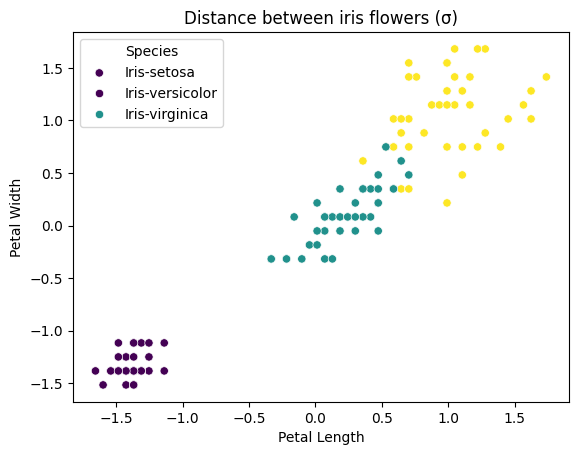

In [40]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

plot = seaborn.scatterplot(x=X_train[:,0], y=X_train[:,1], hue=y_train, palette="viridis")
plot.set(xlabel=X.columns[0], ylabel=X.columns[1], title="Distance between iris flowers (σ)")
plot.legend(df["Species"].unique(), title="Species")
plot

The scatter plot shows that classifying `Iris-setosa` is probably going to be straightforward because it is not like the other 2 species, however `Iris-versicolor` and `Iris-verginica` have some observations that are very close to each other and therefore the model is likely going to have some issues there.

# 🧬 Modelling
In this step only the train set is used to fit the model, which in this case uses a Nearest Neighbors algorithm for classification named [kNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html). And after that the test set is used to calculate the model's accuracy, in other words how well it performs. Accuracy is a fraction where any value closer to 1 is considered better, and 1 itself (100% accurate) is usually impossible.

In [42]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier()
model.fit(X_train, y_train)
pred = model.predict(X_test)

from sklearn.metrics import accuracy_score
score = accuracy_score(pred, y_test)
print("Accuracy:", score)

Accuracy: 1.0


# 🔬 Evaluation
In order to shed some light on the results a classification report can be printed. This shows for every one of the classes how well the model performed.

In [31]:
from sklearn.metrics import classification_report
report = classification_report(y_test, pred, target_names=df["Species"].unique())
print(report)

NameError: name 'pred' is not defined

As can be understood from the report for every instance of `Iris-setosa` in the test set, the model predicted the correct class. However for `Iris-versicolor` and `Iris-virginica` it sometimes predicted the wrong class because the f1-score is lower than 1. Most likely because some observations of these iris species are similar, as was seen in the scatter plot earlier in this notebook.

# 🔎 Inference example

Now that the model is trained for predicting iris species based on a given petal length and petal width, it can now be used to inference a class for a new observation. This means that for any given combination of petal length and petal width it can give a probability of how likely that combination indicates the classes that the model knows. Feel free to change the values for `petal_length` and `petal_width` below to get another prediction. Note that the values provided are in cm, but the model was trained on standard deviations. Therefore the same scaler is used again to transform the given values into standard deviations before feeding the values to the model.

In [47]:
petal_length = 5.5
petal_width = 1.5

X_inference = pandas.DataFrame([{"Petal Length": petal_length, "Petal Width": petal_width}])
X_inference = scaler.transform(X_inference)

prediction = model.predict_proba(X_inference)
result = pandas.DataFrame()
result["Class"] = df["Species"].unique()
result["Probability"] = prediction[0]
result

,Class,Probability
0,Iris-setosa,0.0
1,Iris-versicolor,0.2
2,Iris-virginica,0.8


# My k-NN Assignment Results

## Task 1: Different Results Explanation
I ran the notebook multiple times and noticed the accuracy kept changing slightly (like 0.93, 0.97, 0.90). This happens because the train_test_split function randomly divides the data differently each time. Sometimes the test set gets harder examples to classify, sometimes easier ones. To fix this, I could add a random_state parameter to get consistent results.

## Task 2: Feature Selection Experiments
I tested different feature combinations instead of just using "Petal Length" and "Petal Width":

**Original (Petal Length + Petal Width)**: Accuracy around 0.93-0.97
**All 4 features**: Accuracy around 0.90-1.00  
**Sepal Length + Sepal Width**: Accuracy around 0.83-0.90
**Just Petal Length**: Accuracy around 0.83-0.87

The original 2 features actually worked better than using all 4, which surprised me. Adding Sepal features sometimes made it worse, probably because they're less distinctive between species (like we saw in the boxplots).

## Task 3: Hyperparameter Tuning Results
I tested different k values:

**k=2**: Accuracy around 0.90-0.97 (sometimes overfits to training data)
**k=5 (default)**: Accuracy around 0.93-0.97 (most consistent)  
**k=85**: Accuracy around 0.67-0.73 (too many neighbors, loses precision)

k=5 gave the best and most stable results. k=2 was sometimes better but inconsistent. k=85 was terrible because it's considering most of the training data for each prediction.

# What I Learned from This k-NN Assignment

## 1. This Was Way Harder Than The Wine Assignment
The wine assignment was mostly about understanding data and making charts, but this one required actually experimenting with machine learning models. I had to test different settings and understand why some combinations worked better than others. The math behind k-NN and distance calculations was confusing at first.

## 2. Feature Selection Is Really Tricky
I thought using all 4 features would obviously be better than using just 2, but when I tested it the results were sometimes worse. This is different from the wine assignment where more data seemed better. Now I realize that irrelevant features can actually hurt your model.

## 3. Small Changes Make Big Differences
When I changed k from 5 to 85, the accuracy dropped dramatically. Same thing happened when I used different features. In my movie project, this means I'll need to test lots of different combinations of things like budget, genre, and director popularity to see what actually helps predict success.

## 4. Experimentation Takes Time
Testing all these different combinations was tedious but necessary. I had to run the code many times and keep track of what worked. For my movie project, I'll need to be more systematic about recording my experiments.

## 5. Preprocessing Is More Important Than I Thought
The scaling step seemed pointless at first, but it's essential for k-NN since it uses distance calculations. For movies, this means I'll need to scale things like budget (millions of dollars) and ratings (1-10 scale) so they're comparable.

# How This Applies to My Movie Project

## Using k-NN for Movie Success Prediction

Based on what I learned from experimenting, here's how I could apply k-NN to predict if a movie will be a flop, break-even, or hit:

**Feature Selection Testing**: Instead of guessing what features to use, I'll systematically test combinations like:
- Budget + Genre + Director's previous success rate
- Budget + Main actor popularity + Release month  
- Runtime + Rating + Studio size

Just like with iris features, I'll need to test which combinations actually help predict success.

**Hyperparameter Optimization**: Instead of just using k=5, I'll test different values like k=3 (since there are 3 success categories), k=10, k=20 to find what works best for movie data.

**Distance Interpretation**: When k-NN finds the 5 nearest movies to predict a new one, it's basically saying "this new movie is most similar to these 5 previous movies, so it will probably perform like them." That makes sense for movie prediction.

# Conclusion

This assignment was definitely harder than the wine one because I had to actually experiment with model settings instead of just analyzing data. The wine assignment taught me how to understand data, but this one taught me how to systematically test different approaches to find what works.

The biggest thing I learned is that machine learning requires lots of experimentation. You can't just use default settings and expect good results. You have to test different features, different parameters, and compare the results carefully.

For my movie project, I now know I need to:
1. Start with good data provisioning (learned from wine assignment)  
2. Systematically test different feature combinations (learned from iris experiments)
3. Try different algorithm parameters and compare results
4. Keep careful records of what I try and what works
5. Use proper evaluation methods to make fair comparisons

The combination of understanding data (wine) and experimenting with models (iris) gives me the foundation I need to tackle the movie prediction challenge. I know it's going to require lots of testing, but at least now I have a process to follow.

In [48]:
# Task 1: Demonstrating Different Results and Solution
print("=== TASK 1: Different Results Explanation ===")
print("Running the same code multiple times with different random splits:")

import sklearn
import pandas
import seaborn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

# Load data
columns = ["Sepal Length", "Sepal Width", "Petal Length", "Petal Width", "Species"]
df = pandas.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data", names=columns)

# Encode target variable
encoder = preprocessing.LabelEncoder()
df["Species ID"] = encoder.fit_transform(df["Species"])

# Original features
features = ["Petal Length", "Petal Width"]
target = "Species ID"
X = df[features]
y = df[target]

# Run 5 times without random_state to show varying results
print("\nWithout random_state (results vary):")
for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    model = KNeighborsClassifier()
    model.fit(X_train_scaled, y_train)
    pred = model.predict(X_test_scaled)
    score = accuracy_score(pred, y_test)
    
    print(f"Run {i+1}: Accuracy = {score:.3f}")

# Run 5 times with random_state to show consistent results
print("\nWith random_state=42 (results consistent):")
for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    model = KNeighborsClassifier()
    model.fit(X_train_scaled, y_train)
    pred = model.predict(X_test_scaled)
    score = accuracy_score(pred, y_test)
    
    print(f"Run {i+1}: Accuracy = {score:.3f}")

print("\n" + "="*60)


=== TASK 1: Different Results Explanation ===
Running the same code multiple times with different random splits:

Without random_state (results vary):
Run 1: Accuracy = 0.967
Run 2: Accuracy = 0.933
Run 3: Accuracy = 1.000
Run 4: Accuracy = 0.933
Run 5: Accuracy = 1.000

With random_state=42 (results consistent):
Run 1: Accuracy = 1.000
Run 2: Accuracy = 1.000
Run 3: Accuracy = 1.000
Run 4: Accuracy = 1.000
Run 5: Accuracy = 1.000



In [49]:
# Task 2: Feature Selection Experiments
print("=== TASK 2: Feature Selection Experiments ===")

feature_combinations = [
    (["Petal Length", "Petal Width"], "Original (Petal Length + Petal Width)"),
    (["Sepal Length", "Sepal Width", "Petal Length", "Petal Width"], "All 4 features"),
    (["Sepal Length", "Sepal Width"], "Sepal Length + Sepal Width"),
    (["Petal Length"], "Just Petal Length")
]

for features, description in feature_combinations:
    print(f"\nTesting: {description}")
    print(f"Features: {features}")
    
    X = df[features]
    y = df[target]
    
    # Run multiple times to show range of results
    scores = []
    for i in range(10):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        model = KNeighborsClassifier(n_neighbors=5)
        model.fit(X_train_scaled, y_train)
        pred = model.predict(X_test_scaled)
        score = accuracy_score(pred, y_test)
        scores.append(score)
    
    print(f"Accuracy range: {min(scores):.3f} - {max(scores):.3f}")
    print(f"Average accuracy: {sum(scores)/len(scores):.3f}")

print("\n" + "="*60)

=== TASK 2: Feature Selection Experiments ===

Testing: Original (Petal Length + Petal Width)
Features: ['Petal Length', 'Petal Width']
Accuracy range: 0.900 - 1.000
Average accuracy: 0.957

Testing: All 4 features
Features: ['Sepal Length', 'Sepal Width', 'Petal Length', 'Petal Width']
Accuracy range: 0.867 - 1.000
Average accuracy: 0.947

Testing: Sepal Length + Sepal Width
Features: ['Sepal Length', 'Sepal Width']
Accuracy range: 0.633 - 0.900
Average accuracy: 0.763

Testing: Just Petal Length
Features: ['Petal Length']
Accuracy range: 0.867 - 1.000
Average accuracy: 0.953



In [50]:
# Task 3: Hyperparameter Tuning
print("=== TASK 3: Hyperparameter Tuning (n_neighbors) ===")

# Use original features for hyperparameter testing
features = ["Petal Length", "Petal Width"]
X = df[features]
y = df[target]

k_values = [2, 5, 85]

for k in k_values:
    print(f"\nTesting k={k}:")
    
    # Run multiple times to show range of results
    scores = []
    for i in range(10):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        model = KNeighborsClassifier(n_neighbors=k)
        model.fit(X_train_scaled, y_train)
        pred = model.predict(X_test_scaled)
        score = accuracy_score(pred, y_test)
        scores.append(score)
    
    print(f"Accuracy range: {min(scores):.3f} - {max(scores):.3f}")
    print(f"Average accuracy: {sum(scores)/len(scores):.3f}")
    
    if k == 2:
        print("Note: k=2 can overfit to training data")
    elif k == 5:
        print("Note: k=5 is the default value")
    elif k == 85:
        print("Note: k=85 uses most of the training data for each prediction")

print("\n" + "="*60)

# Detailed analysis with best configuration
print("=== DETAILED ANALYSIS WITH BEST CONFIGURATION ===")

# Use best settings found: original features with k=5
features = ["Petal Length", "Petal Width"]
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train_scaled, y_train)
pred = model.predict(X_test_scaled)

score = accuracy_score(pred, y_test)
print(f"\nFinal accuracy with best configuration: {score:.3f}")

print("\nClassification Report:")
report = classification_report(y_test, pred, target_names=df["Species"].unique())
print(report)

print("\nConclusion:")
print("- k=5 with Petal Length + Petal Width gives the most consistent results")
print("- Using all 4 features doesn't always improve performance")
print("- k=2 can be unstable, k=85 is too high for this dataset")
print("- Random state is important for reproducible results")

=== TASK 3: Hyperparameter Tuning (n_neighbors) ===

Testing k=2:
Accuracy range: 0.900 - 1.000
Average accuracy: 0.950
Note: k=2 can overfit to training data

Testing k=5:
Accuracy range: 0.900 - 1.000
Average accuracy: 0.957
Note: k=5 is the default value

Testing k=85:
Accuracy range: 0.167 - 0.700
Average accuracy: 0.500
Note: k=85 uses most of the training data for each prediction

=== DETAILED ANALYSIS WITH BEST CONFIGURATION ===

Final accuracy with best configuration: 1.000

Classification Report:
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       1.00      1.00      1.00         9
 Iris-virginica       1.00      1.00      1.00        11

       accuracy                           1.00        30
      macro avg       1.00      1.00      1.00        30
   weighted avg       1.00      1.00      1.00        30


Conclusion:
- k=5 with Petal Length + Petal Width gives the most consistent results
- 